# Tutorial 1: Calibrating the Age--Vertical Action Model

We know that stellar age is correlated with certain galactic kinematic properties, including the vertical action (J_z). Since we can calculate the vertical action for virtually all stars in the Gaia catalogue with a radial velocity, we can use this information to constrain stellar ages kinematically (even for very-low-mass stars).

In this tutorial, we will calibrate the dynamical stellar age relation using the vertical action calculated from Gaia data, and an independent source of stellar age. Here, we using asteroseismic ages for red giant branch stars. 

### Before running this tutorial, please download and unzip the `data.zip` file from [the Zenodo database](https://zenodo.org/records/10806816), and move the folder to the current directory. 

### This file contains the example data necessary to run this tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import jax.numpy as jnp

import zoomies

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [12, 8]

## Stokholm RGB Sample

First, we read in a calibration sample of red giant branch stars with asteroseismic ages, crossmatched with Gaia. **Please download the data files (data.zip) from https://zenodo.org/records/10806816, unzip, and place the data folder into this directory!**

We're using the table of stellar ages from [Stokholm et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.524.1634S/abstract). We have previously crossmatched and appended the Gaia DR3 data columns to this table.

If you choose to use your own stellar age calibration dataset, you'll need to ensure that you include the stellar ages along with the Gaia ra, dec, parallax, pmra, pmdec, and radial velocity data columns.

In [2]:
xmatch = Table.read('data/StokholmRGB_GaiaXmatch.csv')

# Getting rid of negative parallaxes
xmatch = xmatch[xmatch['parallax'] > 0]

The function ``calc_jz()`` calculates and saves actions (J_z, J_r, and J_phi) for the calibration stellar sample. The function assumes a Milky Way model from `gala` and wraps the `agama.ActionFinder()` method.

We are using the MilkyWayPotential2022 model built into ``gala.dynamics``.

We are re-saving the calibration table with new action columns via the ``calc_jz`()` function.

In [3]:
zoomies.calc_jz(xmatch,  mwmodel='2022', method='galpy', write=True, fname='data/StokholmRGB_GaiaXmatch_WithActions_2022.fits')

/opt/anaconda3/envs/zoomies_test_2/lib/python3.14/site-packages/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(


Calculating actions with galpy...
/opt/anaconda3/envs/zoomies_test_2/lib/python3.14/site-packages/astropy/units/quantity.py:648: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)

/opt/anaconda3/envs/zoomies_test_2/lib/python3.14/site-packages/astropy/units/quantity.py:1879: RuntimeWarning: Mean of empty slice
  return super().__array_function__(function, types, args, kwargs)



Let's read the saved table with actions back in:

In [4]:
xmatch = Table.read('data/StokholmRGB_GaiaXmatch_WithActions_2022.fits')

In [5]:
# Filter out Nan Jzs
xmatch = xmatch[~np.isnan(xmatch['Jz'])]

# Filter out unreasonably large Jzs
xmatch = xmatch[np.log(xmatch['Jz']) < 20]

We'll calculate an age error column from the percentile values given. We also don't want any negative or zero age errors.

In [6]:
xmatch['age_err'] = np.nanmean((xmatch['LOWER_ERROR_AGE_BASTA']/1000, xmatch['UPPER_ERROR_AGE_BASTA']/1000), axis=0)
xmatch = xmatch[xmatch['age_err'] > 0]

For convenience, we'll define age, ln(J_z), and age error variables from the table.

In [7]:
age = np.array(xmatch['AGE_BASTA'])/1000 # Age in Gyr
lnJz = np.array(np.log(xmatch['Jz']))
age_err = np.array(xmatch['age_err'])

Let's take a look at the calibration sample in age--action space. We can already see the rough age--action trend: as stars get older, ln(Jz) increases.

Text(0.5, 1.0, 'RGB Calibration Sample')

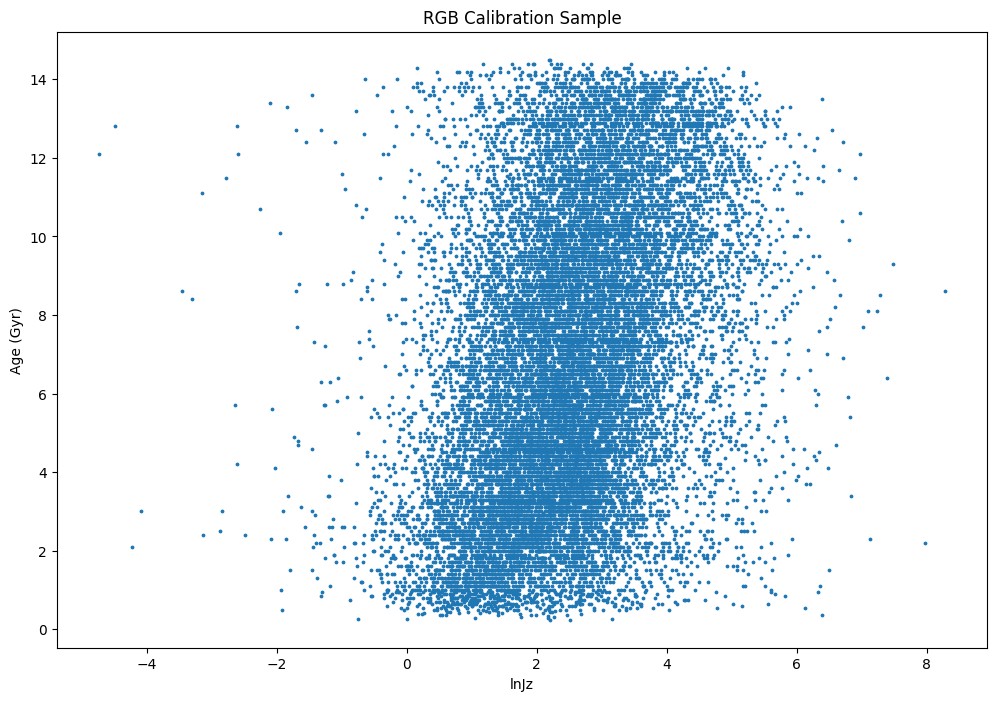

In [8]:
# Calibration sample in age-lnJz space
plt.scatter(lnJz, age, s=3)
plt.xlabel('lnJz')
plt.ylabel('Age (Gyr)')
plt.title('RGB Calibration Sample')

### Calibrating the monotonic age-lnJz spline model

First, let's instantiate a ``zoomies.KinematicAgeSpline`` object using the age, age_error, and lnJz variables we defined above. The``KinematicAgeSpline`` object holds the calibration sample (action, age, and age error) and includes methods to fit a monotonic spline model to the sample.

In [9]:
RGBspline = zoomies.KinematicAgeSpline(jnp.array(lnJz), jnp.array(age), jnp.array(age_err))

With ``KinematicAgeSpline.fit_mono_spline``, you can fit the age--action model (including a monotonic age--lnJz spline) using the calibration sample in one step.

For detailed information on the spline parameters (and why we chose them), see the paper [Sagear et al. (2024)](https://iopscience.iop.org/article/10.3847/1538-4357/ad8b26).

In [10]:
RGBspline.fit_mono_spline(num_warmup=2000, num_samples=2000)

Fitting line...
/opt/anaconda3/envs/zoomies_test_2/lib/python3.14/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound



  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Now let's evaluate the spline model and plot the best-fit spline model against the calibration data:

In [11]:
RGBspline.evaluate_spline()

Text(0.5, 1.0, 'Age vs. $ln(J_z)$')

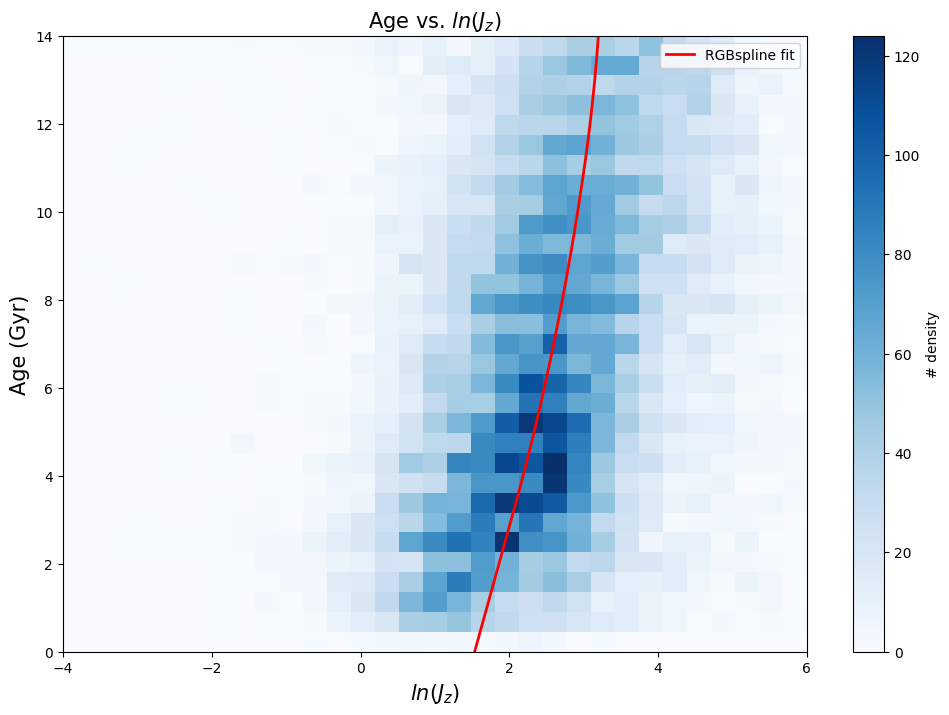

In [12]:
plt.hist2d(RGBspline.lnJz, RGBspline.age, bins=(np.linspace(-4, 6, 32), np.linspace(0, 14, 32)), cmap='Blues')
plt.plot(RGBspline.eval_spline, RGBspline.grid, color='red', label='RGBspline fit', lw=2)

plt.ylabel('Age (Gyr)', fontsize=15);
plt.xlabel('$ln(J_z)$', fontsize=15);
plt.colorbar(label='# density');
plt.legend()
plt.title('Age vs. $ln(J_z)$', fontsize=15)

We can take a look at the sample statistics for the best-fit spline model using ``KinematicAgeSpline.inf_data``:

In [13]:
import arviz as az
az.summary(RGBspline.inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
V,1.325,0.014,1.298,1.352,0.000,0.000,4955.0,2987.0,1.0
age_knot_vals[0],1.340,0.046,1.252,1.425,0.001,0.001,1873.0,2465.0,1.0
age_knot_vals[1],0.172,0.011,0.152,0.192,0.000,0.000,1660.0,2352.0,1.0
age_knot_vals[2],0.119,0.011,0.098,0.139,0.000,0.000,1725.0,2150.0,1.0
age_knot_vals[3],0.084,0.012,0.062,0.106,0.000,0.000,2443.0,2394.0,1.0
age_knot_vals[4],0.016,0.015,0.000,0.043,0.000,0.000,3381.0,2132.0,1.0
dens_knot_vals[0],-9.717,0.286,-10.000,-9.205,0.004,0.007,3412.0,2266.0,1.0
dens_knot_vals[1],4.606,0.085,4.445,4.762,0.001,0.001,4230.0,2341.0,1.0
dens_knot_vals[2],7.029,0.031,6.968,7.089,0.000,0.001,5114.0,3083.0,1.0
dens_knot_vals[3],7.379,0.026,7.332,7.431,0.000,0.000,4870.0,2906.0,1.0


Let's write the calibrated model to a directory:

In [14]:
RGBspline.write(directory='../RGB_spline_model/')

And read it back in just for fun

In [15]:
RGBnewspline = zoomies.read(directory='../RGB_spline_model/')

``RGBnewspline`` has all the same attributes as ``RGBspline``, so you can fit the model once, read it in, and use it again and again to generate age predictions for other stars.

In [16]:
RGBnewspline.evaluate_spline()

Text(0.5, 1.0, 'Age vs. $ln(J_z)$')

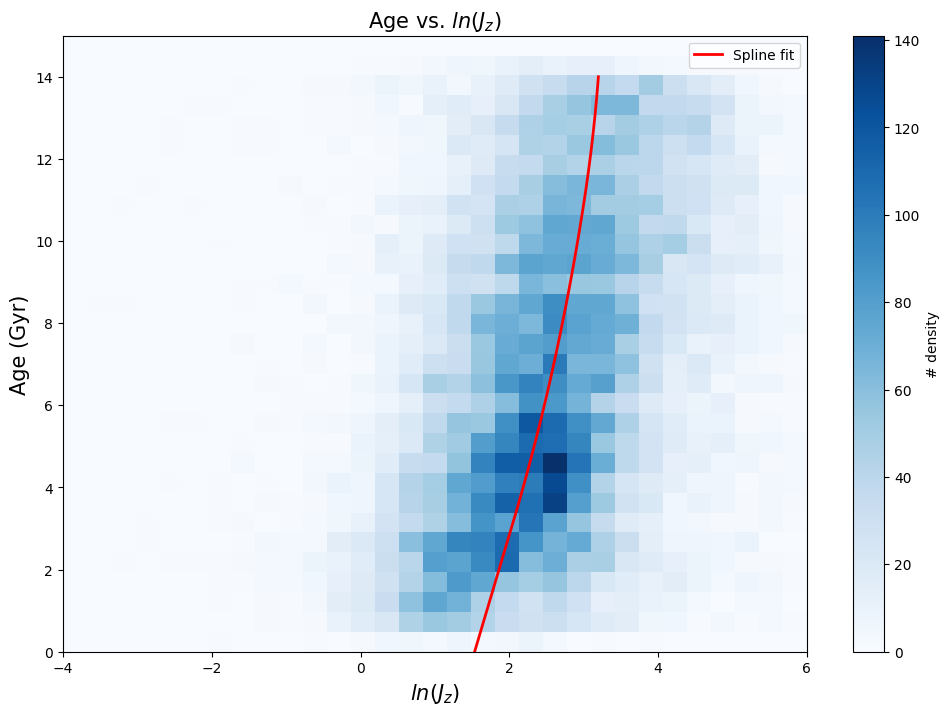

In [17]:
plt.hist2d(RGBnewspline.lnJz, RGBnewspline.age, bins=(np.linspace(-4, 6, 32), np.linspace(0, 15, 32)), cmap='Blues')
plt.plot(RGBnewspline.eval_spline, RGBnewspline.grid, color='red', label='Spline fit', lw=2)

plt.ylabel('Age (Gyr)', fontsize=15);
plt.xlabel('$ln(J_z)$', fontsize=15);
plt.colorbar(label='# density');
plt.legend()
plt.title('Age vs. $ln(J_z)$', fontsize=15)

Using the ``KinematicAgeSpline.evaluate_ages()`` function, you can generate a predicted age probability distribution for any value of ln($J_z$).

``KinematicAgeSpline.evaluate_ages()`` returns two things:

``eval_grid`` is the test age array upon which the age probabilities are evaluated. The test age array consists of evenly sampled ages between 0 and 14 Gyr, and can be changed.

``eval_pdf`` is the kinematic age probability at each point in ``eval_grid``.

**Plotting ``eval_pdf`` vs. ``eval_grid`` gives you the kinematic age probability density function.**

Let's start by creating age probability distributions for some test ln(Jz) values, just to see what they look like:

In [18]:
# evaluate_ages() takes an argument of ln(Jz).

eval_grid, RGBeval_pdf_m3 = RGBnewspline.evaluate_ages(-3)
_, RGBeval_pdf_m1 = RGBnewspline.evaluate_ages(-1)
_, RGBeval_pdf_0 = RGBnewspline.evaluate_ages(0)
_, RGBeval_pdf_1 = RGBnewspline.evaluate_ages(1)
_, RGBeval_pdf_2 = RGBnewspline.evaluate_ages(2)
_, RGBeval_pdf_3 = RGBnewspline.evaluate_ages(3)
_, RGBeval_pdf_4 = RGBnewspline.evaluate_ages(4)
_, RGBeval_pdf_5 = RGBnewspline.evaluate_ages(5)

Text(0.5, 1.0, 'Age Predictions for Test $ln(J_z) Values$')

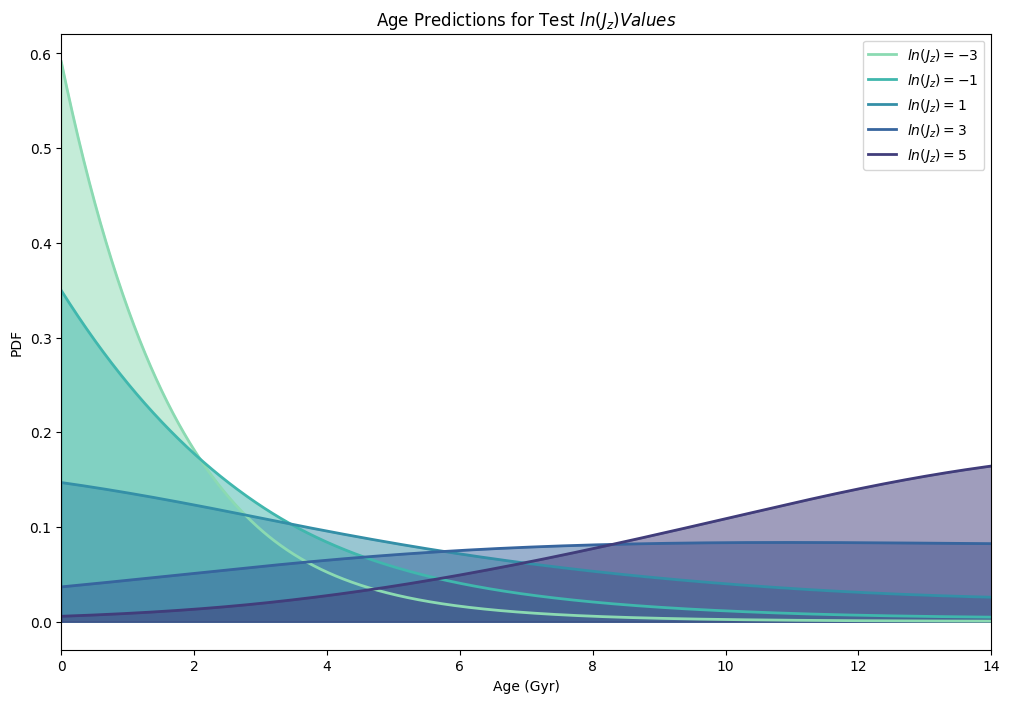

In [23]:
# Install seaborn if you haven't already!
import seaborn as sns

plt.plot(eval_grid, RGBeval_pdf_m3, label='$ln(J_z)=-3$', color=sns.color_palette("mako_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, RGBeval_pdf_m1, label='$ln(J_z)=-1$', color=sns.color_palette("mako_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, RGBeval_pdf_1, label='$ln(J_z) = 1 $', color=sns.color_palette("mako_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, RGBeval_pdf_3, label='$ln(J_z) = 3 $', color=sns.color_palette("mako_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, RGBeval_pdf_5, label='$ln(J_z) = 5 $', color=sns.color_palette("mako_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, RGBeval_pdf_m3, 0, color=sns.color_palette("mako_r").as_hex()[0], alpha=.5)
plt.fill_between(eval_grid, RGBeval_pdf_m1, 0, color=sns.color_palette("mako_r").as_hex()[1], alpha=.5)
plt.fill_between(eval_grid, RGBeval_pdf_1, 0, color=sns.color_palette("mako_r").as_hex()[2], alpha=.5)
plt.fill_between(eval_grid, RGBeval_pdf_3, 0, color=sns.color_palette("mako_r").as_hex()[3], alpha=.5)
plt.fill_between(eval_grid, RGBeval_pdf_5, 0, color=sns.color_palette("mako_r").as_hex()[4], alpha=.5)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.xlim(0,14)

plt.title('Age Predictions for Test $ln(J_z) Values$')

For any star with Gaia data (including radial velocity), you can calculate a ln(Jz) value using the ``zoomies.calc_jz()`` function. See how to generate age probability distributions for other stars in the next tutorial, ``get_age_predictions.ipynb``.

## StarHorse APOGEE Sample (MSTO)

Now, we're going to do the exact same thing as above using a different calibration sample. This is a sample of main-sequence turn-off stars with isochrone ages from the StarHorse catalog [Queiroz et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A&A...673A.155Q). This is intended to show that you can really use any calibration sample you want, given that it's large enough, has reasonably precise independent age measurements, and shows a distinct age--vertical action trend.

Read in data and calculate actions

In [33]:
# Reading calibration sample of MSTO stars with ages, crossmatched with Gaia
starhorse_apogee = Table.read('data/StarHorse_APOGEE_composite.ecsv')
starhorse_apogee = starhorse_apogee[starhorse_apogee['StarHorse_AGE_INOUT'] != 'Warn_diff_inout']

# No negative parallaxes
starhorse_apogee = starhorse_apogee[starhorse_apogee['parallax'] > 0]

# Calculate actions for calibration stars and save
# This step will take a while for large samples
zoomies.calc_jz(starhorse_apogee, mwmodel='2022', method='galpy', write=True, fname='data/StarHorse_APOGEE_composite_WithActions_2022.fits')

/opt/anaconda3/envs/zoomies_test_2/lib/python3.14/site-packages/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(

Calculating actions with galpy...
/opt/anaconda3/envs/zoomies_test_2/lib/python3.14/site-packages/astropy/units/quantity.py:648: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)

/opt/anaconda3/envs/zoomies_test_2/lib/python3.14/site-packages/astropy/units/quantity.py:1879: RuntimeWarning: Mean of empty slice
  return super().__array_function__(function, types, args, kwargs)



In [34]:
# Read table back in
starhorse_apogee = Table.read('data/StarHorse_APOGEE_composite_WithActions_2022.fits')

# No Nan Jzs
starhorse_apogee = starhorse_apogee[~np.isnan(starhorse_apogee['Jz'])]

# No Unreasonably large Jzs
starhorse_apogee = starhorse_apogee[np.log(starhorse_apogee['Jz']) < 20]

# Calculate an age error column -- we don't want negative or zero age errors.
starhorse_apogee['age_err'] = np.array(np.nanmean((starhorse_apogee['age50']-starhorse_apogee['age16'], starhorse_apogee['age84']-starhorse_apogee['age50']), axis=0))
starhorse_apogee = starhorse_apogee[starhorse_apogee['age_err'] > 0]

# Write filtered table again -- now can read in the table without doing any more cuts
starhorse_apogee.write('data/StarHorse_APOGEE_composite_WithActions_2022.fits', overwrite=True)

Start from here if you don't want to do all the calculations again

In [35]:
starhorse_apogee = Table.read('data/StarHorse_APOGEE_composite_WithActions_2022.fits')

In [36]:
age = np.array(starhorse_apogee['age50'])
age_err = np.mean((starhorse_apogee['age50'] - starhorse_apogee['age16'], starhorse_apogee['age84'] - starhorse_apogee['age50']), axis=0)
lnJz = np.array(np.log(starhorse_apogee['Jz']))

Text(0.5, 1.0, 'MSTO Calibration Sample')

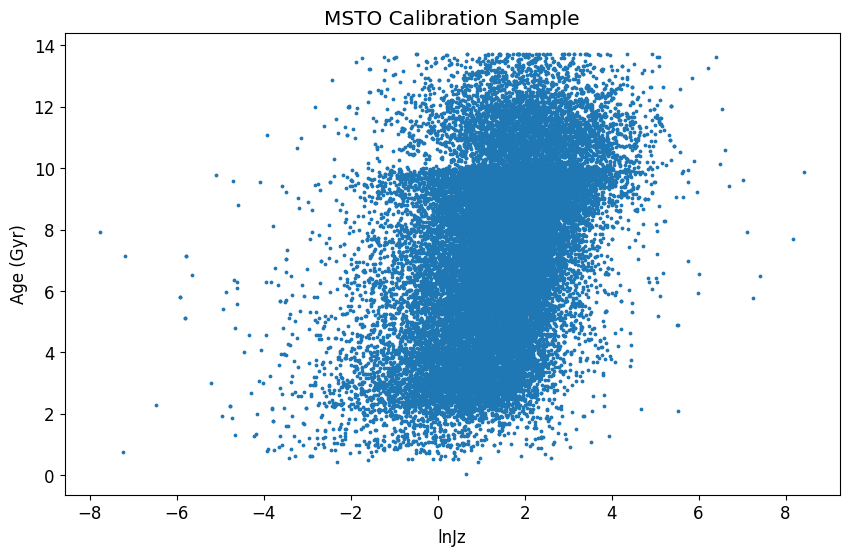

In [37]:
plt.scatter(lnJz, age, s=3)

plt.xlabel('lnJz')
plt.ylabel('Age (Gyr)')

plt.title('MSTO Calibration Sample')

Calibrate monotonic spline model

In [38]:
MSTOspline = zoomies.KinematicAgeSpline(jnp.array(lnJz), jnp.array(age), jnp.array(age_err))
MSTOspline.fit_mono_spline(num_warmup=2000, num_samples=2000)

Fitting line...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

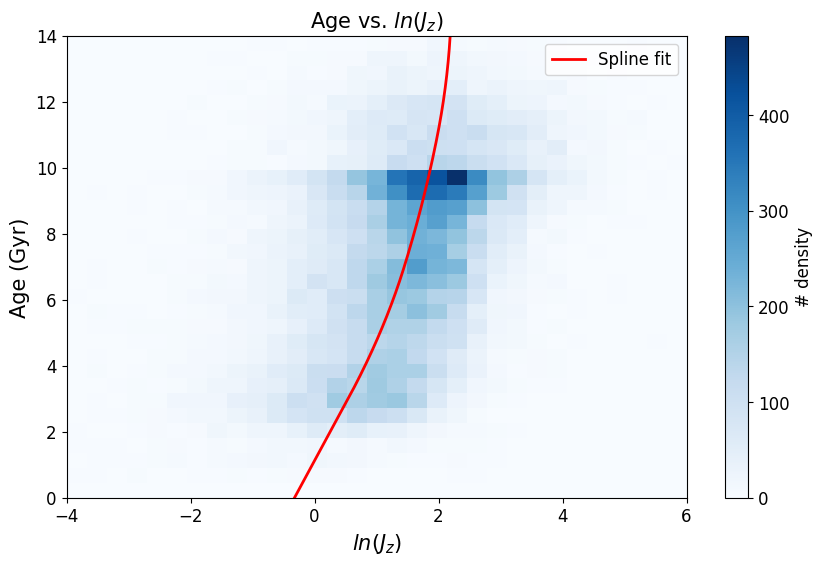

In [39]:
MSTOspline.plot_fit()

In [40]:
import arviz as az
az.summary(MSTOspline.inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
V,1.244,0.010,1.226,1.262,0.000,0.000,5537.0,2637.0,1.0
age_knot_vals[0],-0.648,0.053,-0.743,-0.546,0.001,0.001,2227.0,2737.0,1.0
age_knot_vals[1],0.295,0.011,0.274,0.316,0.000,0.000,2099.0,2708.0,1.0
age_knot_vals[2],0.161,0.008,0.147,0.176,0.000,0.000,2325.0,2844.0,1.0
age_knot_vals[3],0.102,0.011,0.082,0.121,0.000,0.000,3531.0,3046.0,1.0
age_knot_vals[4],0.014,0.014,0.000,0.038,0.000,0.000,3560.0,1660.0,1.0
dens_knot_vals[0],-9.350,0.628,-10.000,-8.176,0.008,0.013,3908.0,1964.0,1.0
dens_knot_vals[1],3.332,0.161,3.026,3.622,0.002,0.002,5456.0,3225.0,1.0
dens_knot_vals[2],5.667,0.052,5.567,5.766,0.001,0.001,6134.0,2833.0,1.0
dens_knot_vals[3],7.611,0.023,7.567,7.656,0.000,0.000,6357.0,3316.0,1.0


In [42]:
MSTOspline.write(directory='../MSTO_spline_model/')

In [43]:
MSTOnewspline = zoomies.read(directory='../MSTO_spline_model/')

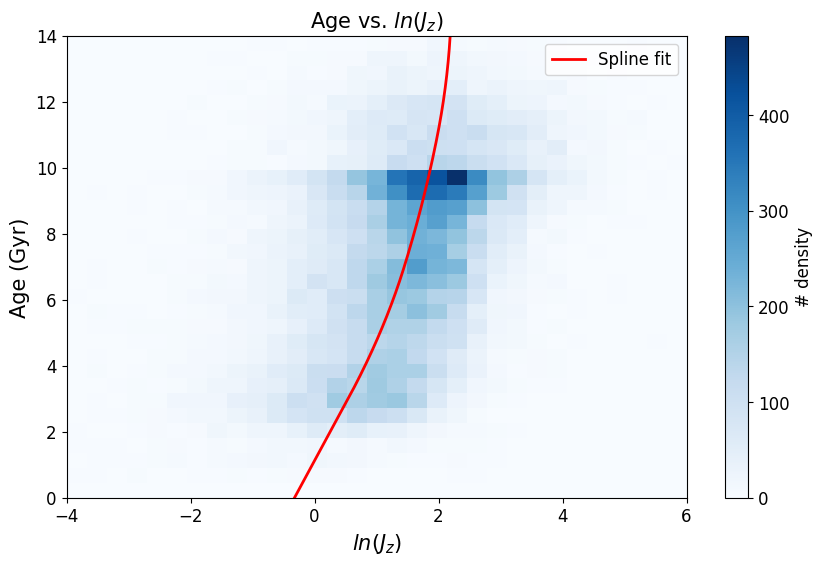

In [44]:
MSTOnewspline.plot_fit()

In [45]:
eval_grid, MSTOeval_pdf_m3 = MSTOnewspline.evaluate_ages(-3)
_, MSTOeval_pdf_m1 = MSTOnewspline.evaluate_ages(-1)
_, MSTOeval_pdf_0 = MSTOnewspline.evaluate_ages(0)
_, MSTOeval_pdf_1 = MSTOnewspline.evaluate_ages(1)
_, MSTOeval_pdf_2 = MSTOnewspline.evaluate_ages(2)
_, MSTOeval_pdf_3 = MSTOnewspline.evaluate_ages(3)
_, MSTOeval_pdf_4 = MSTOnewspline.evaluate_ages(4)
_, MSTOeval_pdf_5 = MSTOnewspline.evaluate_ages(5)

Text(0.5, 1.0, 'Age Predictions for Test $ln(J_z)$ Values: MSTO Calibrated')

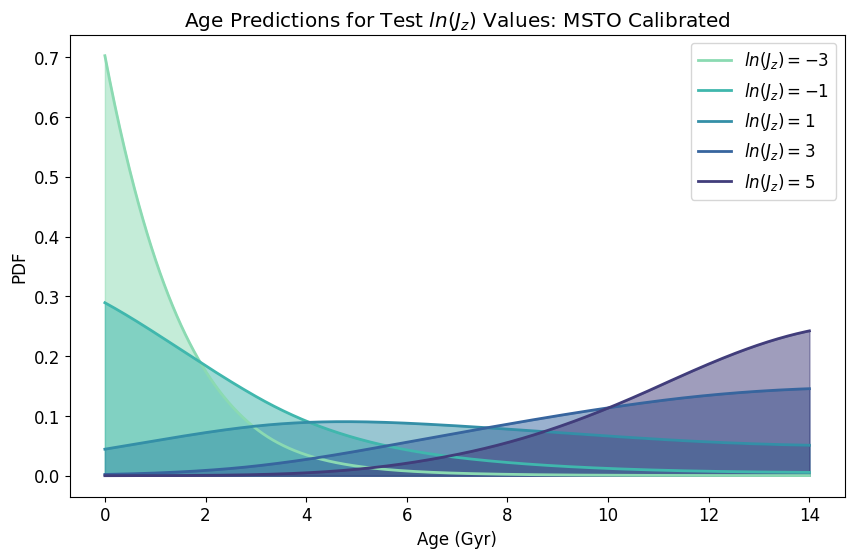

In [46]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

plt.plot(eval_grid, MSTOeval_pdf_m3, label='$ln(J_z)=-3$', color=sns.color_palette("mako_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, MSTOeval_pdf_m1, label='$ln(J_z)=-1$', color=sns.color_palette("mako_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, MSTOeval_pdf_1, label='$ln(J_z) = 1 $', color=sns.color_palette("mako_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, MSTOeval_pdf_3, label='$ln(J_z) = 3 $', color=sns.color_palette("mako_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, MSTOeval_pdf_5, label='$ln(J_z) = 5 $', color=sns.color_palette("mako_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, MSTOeval_pdf_m3, 0, color=sns.color_palette("mako_r").as_hex()[0], alpha=.5)
plt.fill_between(eval_grid, MSTOeval_pdf_m1, 0, color=sns.color_palette("mako_r").as_hex()[1], alpha=.5)
plt.fill_between(eval_grid, MSTOeval_pdf_1, 0, color=sns.color_palette("mako_r").as_hex()[2], alpha=.5)
plt.fill_between(eval_grid, MSTOeval_pdf_3, 0, color=sns.color_palette("mako_r").as_hex()[3], alpha=.5)
plt.fill_between(eval_grid, MSTOeval_pdf_5, 0, color=sns.color_palette("mako_r").as_hex()[4], alpha=.5)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.title('Age Predictions for Test $ln(J_z)$ Values: MSTO Calibrated')